# I. Prepare variables for models

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import pickle 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import warnings

In [2]:
df = pd.DataFrame.from_csv('L2 - Dataframe1.csv')
df

,title,dtg,distributor,release,genre,runtime,rating,budget,foreign,director,...,number_charts,rank,life_theaters,opening_gross,opening_theaters,year,director_dummy,writer_dummy,composer_dummy,producer_dummy
0,The Birdcage,124060553.0,MGM,1996-03-08,Comedy,117.0,R,NaN,61200000.0,Mike Nichols,...,46.0,1,NaN,18275828.0,NaN,1996.0,1,0,0,1
1,Interview with the Vampire,105264608.0,Warner Bros.,1994-11-11,Period Horror,123.0,R,NaN,118400000.0,Neil Jordan,...,35.0,2,NaN,36389705.0,NaN,1994.0,1,0,1,0
2,The Imitation Game,91125683.0,Weinstein Company,2014-11-28,Drama,114.0,PG-13,NaN,142430025.0,Morten Tyldum,...,25.0,3,NaN,479352.0,4.0,2014.0,1,1,1,1
3,Brokeback Mountain,83043761.0,Focus Features,2005-12-09,Western,135.0,R,NaN,95018998.0,Ang Lee,...,25.0,4,NaN,547425.0,5.0,2005.0,1,0,0,0
4,The Talented Mr. Ripley,81298265.0,Paramount,1999-12-25,Thriller,139.0,R,NaN,47500000.0,Anthony Minghella,...,20.0,5,NaN,12738237.0,NaN,1999.0,1,0,1,1
5,Philadelphia,77446440.0,TriStar,1993-12-24,Drama,125.0,PG-13,NaN,129232000.0,Jonathan Demme,...,21.0,6,NaN,143433.0,4.0,1993.0,1,0,1,1
6,In & Out,63856929.0,Paramount,1997-09-19,Comedy,92.0,PG-13,NaN,NaN,Frank Oz,...,16.0,7,NaN,15019821.0,NaN,1997.0,1,1,1,1
7,The Crying Game,62548947.0,Miramax,1992-11-27,Drama / Thriller,112.0,R,NaN,NaN,Neil Jordan,...,18.0,8,NaN,101107.0,6.0,1992.0,1,0,0,0
8,Bruno,60054530.0,Universal,2009-07-10,Comedy,88.0,R,NaN,78751301.0,Larry Charles,...,24.0,9,NaN,30619130.0,NaN,2009.0,1,1,1,1
9,The Hours,41675994.0,Paramount,2002-12-27,Drama,114.0,PG-13,NaN,67170078.0,Stephen Daldry,...,21.0,10,NaN,338622.0,11.0,2002.0,1,1,1,1


In [3]:
df.shape

(351, 26)

In [4]:
# Scrape adjusted for inflation data

gay_adjusted_list = []
url_adjusted_list = []
gay_movies_adjusted_urls = []
    
for i in range(1,5):
    url = 'http://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum=adjust_yr=2016&pagenum=' + str(i) + '&id=gay.htm'
    url_adjusted_list.append(url)

for url in url_adjusted_list:
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,'lxml')

    tables = soup.find_all("table")
    rows = [row for row in tables[2].find_all('tr')]
    rows = rows[2:102]

    for row in rows:
        cells = row.find_all('td')
        for i in range(len(cells)//8):
            gay_adjusted_list.append([a.text for a in cells[i*8:(i+1)*8]])
            gay_movies_adjusted_urls.append(row.find('a')['href'])
            
df_gay_adjusted_list = pd.DataFrame(gay_adjusted_list)

list_adjusted_head = ['rank', 'title', 'distributor','adjusted_total_gross',\
                      'life_theaters', 'opening_adjusted_gross', 'opening_theaters', 'list_date'] 

df_gay_adjusted_list.columns = list_adjusted_head
df_gay_adjusted_list = df_gay_adjusted_list.drop(['rank', 'distributor','life_theaters', \
                                                  'opening_theaters', 'list_date'], 1)
df_gay_adjusted_list.head()

,title,adjusted_total_gross,opening_adjusted_gross
0,The Birdcage,"$124,060,553","$18,275,828"
1,Interview with the Vampire,"$105,264,608","$36,389,705"
2,The Imitation Game,"$91,125,683","$479,352"
3,Brokeback Mountain,"$83,043,761","$547,425"
4,The Talented Mr. Ripley,"$81,298,265","$12,738,237"


In [5]:
# Final dataframe

df = pd.merge(df, df_gay_adjusted_list, on='title', how='left')
df.head()

,title,dtg,distributor,release,genre,runtime,rating,budget,foreign,director,...,life_theaters,opening_gross,opening_theaters,year,director_dummy,writer_dummy,composer_dummy,producer_dummy,adjusted_total_gross,opening_adjusted_gross
0,The Birdcage,124060553.0,MGM,1996-03-08,Comedy,117.0,R,NaN,61200000.0,Mike Nichols,...,NaN,18275828.0,NaN,1996.0,1,0,0,1,"$124,060,553","$18,275,828"
1,Interview with the Vampire,105264608.0,Warner Bros.,1994-11-11,Period Horror,123.0,R,NaN,118400000.0,Neil Jordan,...,NaN,36389705.0,NaN,1994.0,1,0,1,0,"$105,264,608","$36,389,705"
2,The Imitation Game,91125683.0,Weinstein Company,2014-11-28,Drama,114.0,PG-13,NaN,142430025.0,Morten Tyldum,...,NaN,479352.0,4.0,2014.0,1,1,1,1,"$91,125,683","$479,352"
3,Brokeback Mountain,83043761.0,Focus Features,2005-12-09,Western,135.0,R,NaN,95018998.0,Ang Lee,...,NaN,547425.0,5.0,2005.0,1,0,0,0,"$83,043,761","$547,425"
4,The Talented Mr. Ripley,81298265.0,Paramount,1999-12-25,Thriller,139.0,R,NaN,47500000.0,Anthony Minghella,...,NaN,12738237.0,NaN,1999.0,1,0,1,1,"$81,298,265","$12,738,237"


In [6]:
df.dtypes

title                      object
dtg                       float64
distributor                object
release                    object
genre                      object
runtime                   float64
rating                     object
budget                    float64
foreign                   float64
director                   object
actor                       int64
producer                   object
composer                   object
writer                     object
oscar                     float64
number_genres             float64
number_charts             float64
rank                       object
life_theaters             float64
opening_gross             float64
opening_theaters          float64
year                      float64
director_dummy              int64
writer_dummy                int64
composer_dummy              int64
producer_dummy              int64
adjusted_total_gross       object
opening_adjusted_gross     object
dtype: object

In [7]:
def money_to_int(moneystring):
    try:
        moneystring =  moneystring.replace('$','').replace(',','')
        return int(moneystring)
    except:
        pass
    
df.adjusted_total_gross = df.adjusted_total_gross.apply(lambda x: money_to_int(x))
df.opening_adjusted_gross = df.opening_adjusted_gross.apply(lambda x: money_to_int(x))

In [8]:
df.to_csv('L3 - Dataframe1.csv')

In [9]:
df2 = df.drop(['title', 'dtg', "opening_gross","budget", "foreign", "rank", 'director', \
               'producer', 'composer', 'writer'], 1)
df2.count()

distributor               341
release                   341
genre                     341
runtime                   335
rating                    341
actor                     352
oscar                     341
number_genres             341
number_charts             337
life_theaters             299
opening_theaters          307
year                      341
director_dummy            352
writer_dummy              352
composer_dummy            352
producer_dummy            352
adjusted_total_gross      338
opening_adjusted_gross    319
dtype: int64

In [10]:
df2.isnull().sum()

distributor               11
release                   11
genre                     11
runtime                   17
rating                    11
actor                      0
oscar                     11
number_genres             11
number_charts             15
life_theaters             53
opening_theaters          45
year                      11
director_dummy             0
writer_dummy               0
composer_dummy             0
producer_dummy             0
adjusted_total_gross      14
opening_adjusted_gross    33
dtype: int64

In [11]:
df3 = df2.dropna(axis=0, how='any')
df3.reset_index(inplace=True, drop=True)
df3.head()

,distributor,release,genre,runtime,rating,actor,oscar,number_genres,number_charts,life_theaters,opening_theaters,year,director_dummy,writer_dummy,composer_dummy,producer_dummy,adjusted_total_gross,opening_adjusted_gross
0,Focus Features,2008-11-26,Drama,128.0,R,5,8.0,1.0,22.0,882.0,36.0,2008.0,1,1,1,1,31841299.0,1453844.0
1,MGM,1982-03-19,Musical,132.0,PG,2,7.0,4.0,21.0,615.0,3.0,1982.0,0,0,0,0,28215453.0,139634.0
2,Miramax,2002-10-25,Period Drama,123.0,R,7,6.0,2.0,18.0,794.0,5.0,2002.0,1,0,1,1,25885000.0,205996.0
3,Focus Features,2010-07-09,Comedy,106.0,R,5,4.0,1.0,12.0,994.0,7.0,2010.0,1,1,1,1,20811365.0,491971.0
4,Island Alive,1985-07-26,Drama,111.0,R,1,4.0,1.0,14.0,204.0,1.0,1985.0,0,0,0,0,17005229.0,55962.0


In [12]:
df3.isnull().sum()

distributor               0
release                   0
genre                     0
runtime                   0
rating                    0
actor                     0
oscar                     0
number_genres             0
number_charts             0
life_theaters             0
opening_theaters          0
year                      0
director_dummy            0
writer_dummy              0
composer_dummy            0
producer_dummy            0
adjusted_total_gross      0
opening_adjusted_gross    0
dtype: int64

In [13]:
df3.count()

distributor               281
release                   281
genre                     281
runtime                   281
rating                    281
actor                     281
oscar                     281
number_genres             281
number_charts             281
life_theaters             281
opening_theaters          281
year                      281
director_dummy            281
writer_dummy              281
composer_dummy            281
producer_dummy            281
adjusted_total_gross      281
opening_adjusted_gross    281
dtype: int64

In [14]:
# Categorize variables

form = 'distributor+genre+rating'
df4 = patsy.dmatrix(form, data=df3,return_type='dataframe')
df4.columns

Index([u'Intercept', u'distributor[T.Ariztical Entertainment]',
       u'distributor[T.Artisan]', u'distributor[T.Avatar]',
       u'distributor[T.Breaking Glass Pictures]',
       u'distributor[T.Cafe Entertainment Studio]', u'distributor[T.Cinecom]',
       u'distributor[T.Cinedigm Entertainment]',
       u'distributor[T.Cohen Media Group]', u'distributor[T.Cowboy]',
       ...
       u'genre[T.Period Drama]', u'genre[T.Romance]',
       u'genre[T.Romantic Comedy]', u'genre[T.Sports Drama]',
       u'genre[T.Thriller]', u'genre[T.Unknown]', u'rating[T.PG]',
       u'rating[T.PG-13]', u'rating[T.R]', u'rating[T.Unrated]'],
      dtype='object', length=110)

In [15]:
df5 = pd.concat([df3, df4], 1)
df5.shape

(281, 128)

In [16]:
df6 = df5.drop(['release','distributor', 'genre', 'rating'], 1)
df6.shape

(281, 124)

# II. Graph variables

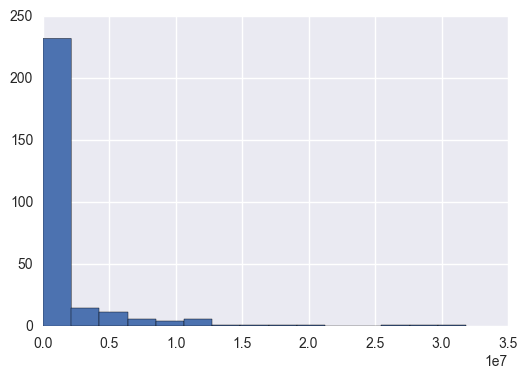

In [17]:
df6.adjusted_total_gross.hist(bins=15)

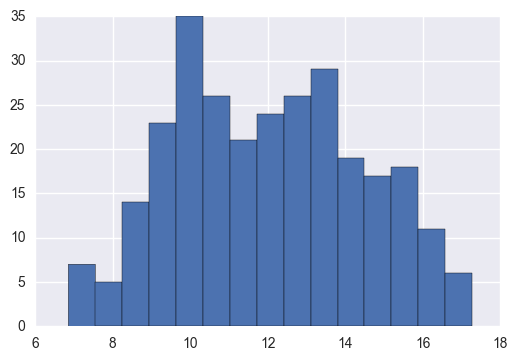

In [18]:
df6['log_adj_total'] = np.log(df6.adjusted_total_gross)
df6.log_adj_total.hist(bins=15)

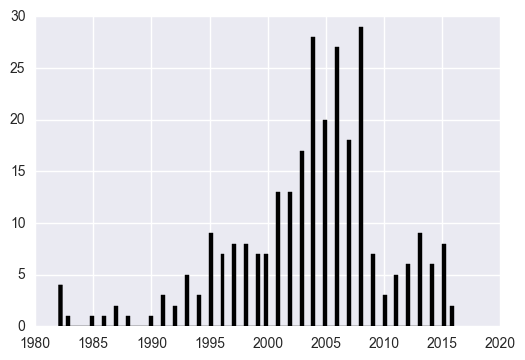

In [19]:
df6.year.hist(color='black', bins=100)

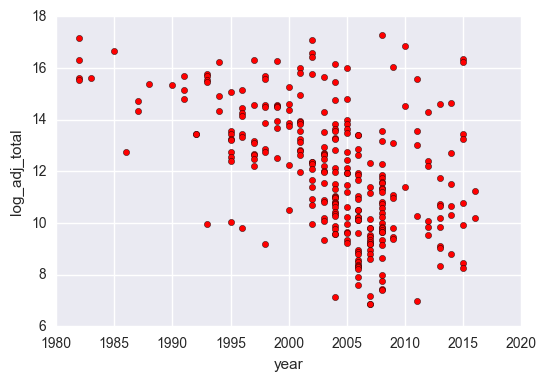

In [20]:
df6.plot(x='year',y='log_adj_total',kind='scatter', color='red')

In [21]:
df6.describe()

,runtime,actor,oscar,number_genres,number_charts,life_theaters,opening_theaters,year,director_dummy,writer_dummy,...,genre[T.Romance],genre[T.Romantic Comedy],genre[T.Sports Drama],genre[T.Thriller],genre[T.Unknown],rating[T.PG],rating[T.PG-13],rating[T.R],rating[T.Unrated],log_adj_total
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.00000,281.000000,281.000000,281.000000,281.000000,...,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,98.128114,0.889680,0.231317,1.508897,7.434164,72.02847,21.565836,2003.604982,0.174377,0.128114,...,0.028470,0.071174,0.003559,0.010676,0.167260,0.007117,0.064057,0.498221,0.412811,12.026109
std,15.521573,1.582922,0.978272,0.671426,3.159471,172.50948,104.524656,6.635713,0.380110,0.334813,...,0.166607,0.257575,0.059655,0.102956,0.373873,0.084214,0.245291,0.500889,0.493218,2.422670
min,60.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1982.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.855409
25%,89.000000,0.000000,0.000000,1.000000,7.000000,2.00000,1.000000,2001.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.091501
50%,96.000000,0.000000,0.000000,1.000000,8.000000,7.00000,2.000000,2004.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.983448
75%,105.000000,1.000000,0.000000,2.000000,8.000000,40.00000,6.000000,2008.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,13.816425
max,179.000000,7.000000,8.000000,5.000000,22.000000,994.00000,877.000000,2016.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.276275


In [22]:
# Normalize

from sklearn import preprocessing

df7 = preprocessing.normalize(df6, axis=0,norm='max')
df7 = pd.DataFrame(df7, columns=df6.columns)
df7.to_csv('L4 - Final variables.csv')
df7.describe()

,runtime,actor,oscar,number_genres,number_charts,life_theaters,opening_theaters,year,director_dummy,writer_dummy,...,genre[T.Romance],genre[T.Romantic Comedy],genre[T.Sports Drama],genre[T.Thriller],genre[T.Unknown],rating[T.PG],rating[T.PG-13],rating[T.R],rating[T.Unrated],log_adj_total
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,...,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.548202,0.127097,0.028915,0.301779,0.337917,0.072463,0.024590,0.993852,0.174377,0.128114,...,0.028470,0.071174,0.003559,0.010676,0.167260,0.007117,0.064057,0.498221,0.412811,0.696105
std,0.086713,0.226132,0.122284,0.134285,0.143612,0.173551,0.119184,0.003292,0.380110,0.334813,...,0.166607,0.257575,0.059655,0.102956,0.373873,0.084214,0.245291,0.500889,0.493218,0.140231
min,0.335196,0.000000,0.000000,0.200000,0.045455,0.001006,0.001140,0.983135,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396811
25%,0.497207,0.000000,0.000000,0.200000,0.318182,0.002012,0.001140,0.992560,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.584125
50%,0.536313,0.000000,0.000000,0.200000,0.363636,0.007042,0.002281,0.994048,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693636
75%,0.586592,0.142857,0.000000,0.400000,0.363636,0.040241,0.006842,0.996032,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.799734
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# III. OLS

In [24]:
y = df7.log_adj_total
x = df7.drop(['log_adj_total', 'adjusted_total_gross'], 1)
y_forever = y
x_forever = x

In [25]:
kf = KFold(n=len(x), n_folds=3, shuffle=True)
all_scores = []

# get indices of corresponding train & test
for train,test in kf:
    x_train = x.iloc[train]
    y_train = y.iloc[train]
    x_test = x.iloc[test]
    y_test = y.iloc[test]
    pvals = []
    sig_cols = []
    
    model = sm.OLS(y_train, x_train)
    est = model.fit()
    pvals = est.pvalues.sort_values()
    # we can eliminate features iteratively
    
    for i in range(15):
        ## recalculate pvalue
        pvals = pvals[:-6]   ## remove 6 features at a time
        feature_keep = pvals.index  #print(len(feature_keep))
        
        x_train = x_train[feature_keep]
        x_test=x_test[feature_keep]
        # fit model to training data
        model=sm.OLS(y_train,x_train)
        est=model.fit()
        pvals=est.pvalues.sort_values() 
        y_train_pred=est.predict(x_train)
        y_test_pred=est.predict(x_test)
        
    
    r_2=est.rsquared
    all_scores.append(r_2)
        
np.mean(all_scores)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_adj_total   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     16.25
Date:                Sun, 29 Jan 2017   Prob (F-statistic):           2.99e-33
Time:                        16:28:20   Log-Likelihood:                 230.32
No. Observations:                 188   AIC:                            -404.6
Df Residuals:                     160   BIC:                            -314.0
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
distributor[T.Microangelo Entertainment] -3.958e-15   3.79e-16    -10.446      0.000     -4.71e-15 -3.21e-15
Intercept                                   22.0363      2.039     10.806      0.000        18.009    26.064
year                                       -21.6770      2.054    -10.554      0.000       -25.733   -17.621
distributor[T.Gravitas Ventures]          1.021e-12   9.56e-14     10.679      0.000      8.32e-13  1.21e-12
distributor[T.Cohen Media Group]         -4.582e-13   4.29e-14    -10.681      0.000     -5.43e-13 -3.73e-13
distributor[T.Focus Features]                0.2109      0.034      6.149      0.000         0.143     0.279
distributor[T.Avatar]                    -1.592e-14    1.5e-15    -10.605      0.000     -1.89e-14  -1.3e-14
distributor[T.Lot 47]                    -2.039e-13   1.91e-14    -10.674      0.000     -2.42e-13 -1.66e-13
producer_dummy                               0.0954      0.018      5.208      0.000         0.059     0.132
rating[T.PG-13]                             -0.0896      0.026     -3.397      0.001        -0.142    -0.038
runtime                                      0.2776      0.077      3.611      0.000         0.126     0.429
distributor[T.Sony Classics]                 0.0860      0.030      2.887      0.004         0.027     0.145
genre[T.Drama]                               0.0536      0.017      3.138      0.002         0.020     0.087
distributor[T.IDP]                           0.1346      0.046      2.903      0.004         0.043     0.226
genre[T.Period Drama]                        0.0877      0.032      2.725      0.007         0.024     0.151
distributor[T.IFC]                           0.0723      0.028      2.550      0.012         0.016     0.128
genre[T.Comedy]                              0.0695      0.021      3.244      0.001         0.027     0.112
distributor[T.Fox Searchlight]               0.1070      0.042      2.566      0.011         0.025     0.189
rating[T.Unrated]                           -0.0474      0.016     -3.036      0.003        -0.078    -0.017
distributor[T.Zeitgeist]                     0.1325      0.056      2.350      0.020         0.021     0.244
distributor[T.Miramax]                       0.0769      0.038      2.016      0.045         0.002     0.152
distributor[T.New Yorker]                    0.1826      0.078      2.330      0.021         0.028     0.337
distributor[T.Lovett Releasing]              0.1853      0.079      2.346      0.020         0.029     0.341
distributor[T.Lionsgate]                     0.1784      0.084      2.124      0.035         0.013     0.344
genre[T.Romantic Comedy]                     0.0475      0.023      2.042      0.043         0.002     0.093
distributor[T.Logo Features]   

In [26]:
# OLS on test data

resid = y_test - y_test_pred
1- resid.map(lambda x: x**2).sum()

-0.08941083469503841

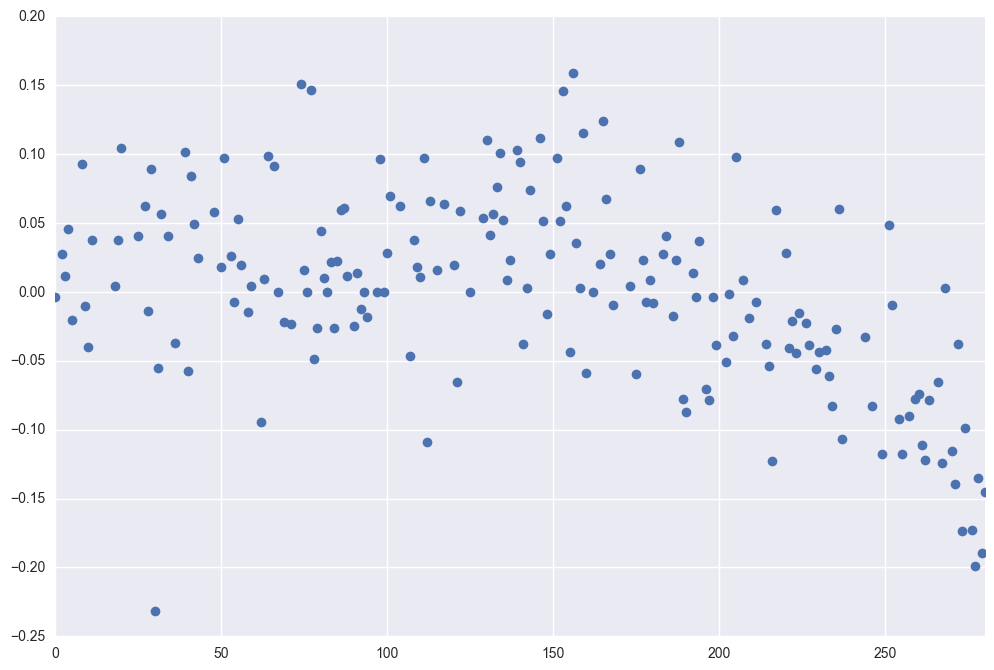

In [27]:
# Plotted residuals

est.resid.plot(style='o', figsize=(12,8))

0.732789392541
0.434654368101


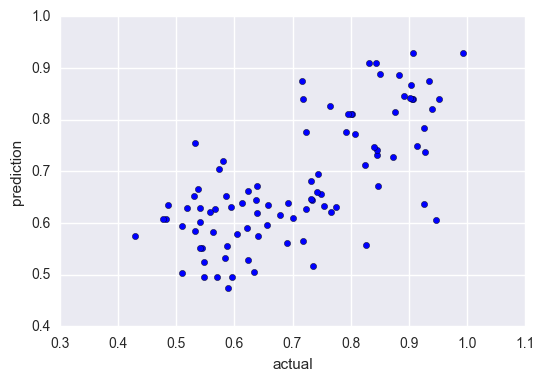

In [28]:
from sklearn.metrics import mean_squared_error
#print y_test_pred
mean_y_test = np.mean(y_test)
mean_y_train = np.mean(y_train)

# print mean_squared_error(y_test, y_test_pred)
print 1 - (mean_squared_error(y_train, y_train_pred)/mean_squared_error([mean_y_train]*len(y_train), y_train))
print 1 - (mean_squared_error(y_test, y_test_pred)/mean_squared_error([mean_y_test]*len(y_test), y_test))

# Plot test vs test_pred
plt.scatter(y_test, y_test_pred)
plt.xlabel("actual")
plt.ylabel("prediction");

# IV. LASSO!

In [29]:
y = df7.log_adj_total
x = df7.drop(['log_adj_total', 'adjusted_total_gross'], 1)
y_forever = y
x_forever = x

X_train, X_test, y_train, y_test = train_test_split(x_forever, y_forever, test_size=0.2)  
X = x_forever
y = y_forever

In [30]:
from sklearn.linear_model import Lasso

kf = KFold(n=len(X), n_folds=4, shuffle=True)

all_scores=[]
alphas=[1e-4,0.5*1e-3,1e-3,0.5*1e-2]


for train, test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        estL=Lasso(alpha=a)
        estL.fit(x_train,y_train)
        mse=np.mean((y_test-estL.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

print all_scores

[[0.012101401132193034, 0.010388330550296986, 0.009484192142569514, 0.010624030719742465], [0.00896002813944823, 0.0068807390130151665, 0.006534898911968794, 0.007948228682686279], [0.01010090140597542, 0.010558318032678614, 0.010948516894199999, 0.010766694288423988], [0.007644585298137567, 0.0067688588345562115, 0.006700189754055639, 0.007874775958528459]]


/Users/lorenadelaparralanda/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


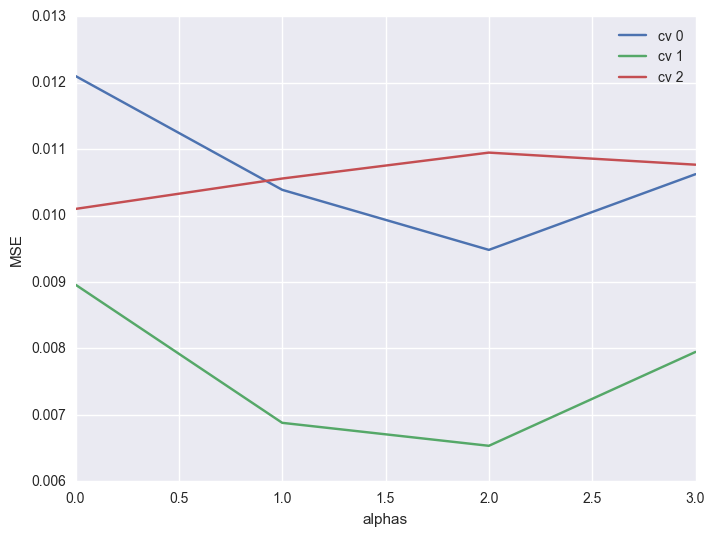

In [31]:
plt.figure(figsize=(8,6))
# plt.ylim(0,8)
plt.legend()
for i in range(3):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x_forever, y_forever, test_size=0.2)

estL=Lasso(alpha=0.5*1e-2) 
estL.fit(X_train,y_train)
estL.alpha

zipped=zip(X.columns,estL.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
print features[:20]

print estL.score(X_test, y_test)
print estL.score(X_train, y_train)

[('life_theaters', 0.10029092220112876), ('director_dummy', 0.051021179300001072), ('rating[T.R]', 0.018209385506893272), ('producer_dummy', 0.011633805345563313), ('runtime', 0.0), ('actor', 0.0), ('oscar', 0.0), ('number_genres', 0.0), ('number_charts', 0.0), ('opening_theaters', 0.0), ('year', -0.0), ('writer_dummy', 0.0), ('composer_dummy', 0.0), ('opening_adjusted_gross', 0.0), ('Intercept', 0.0), ('distributor[T.Ariztical Entertainment]', 0.0), ('distributor[T.Artisan]', -0.0), ('distributor[T.Avatar]', -0.0), ('distributor[T.Breaking Glass Pictures]', -0.0), ('distributor[T.Cafe Entertainment Studio]', -0.0)]
0.465890223899
0.581074088853


# V. Explore significant variables 

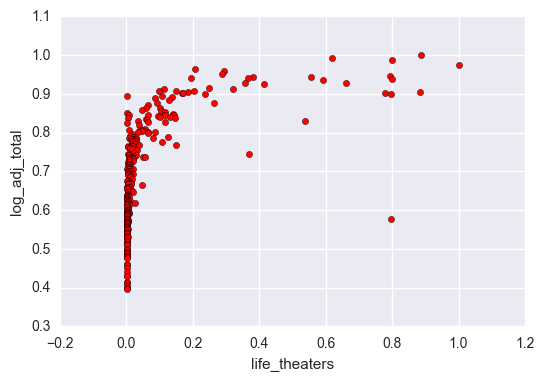

In [33]:
df7.plot(x='life_theaters',y='log_adj_total',kind='scatter', color='red')

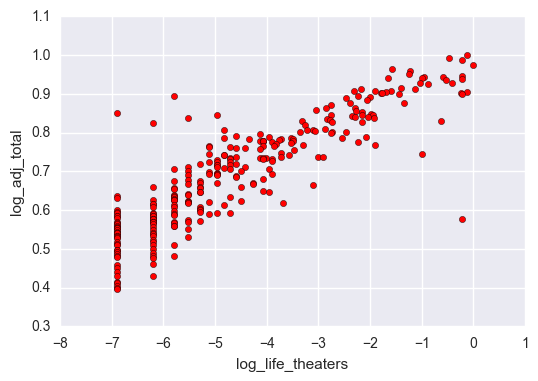

In [34]:
df7['log_life_theaters'] = np.log(df7.life_theaters)
df7.plot(x='log_life_theaters',y='log_adj_total',kind='scatter', color='red')

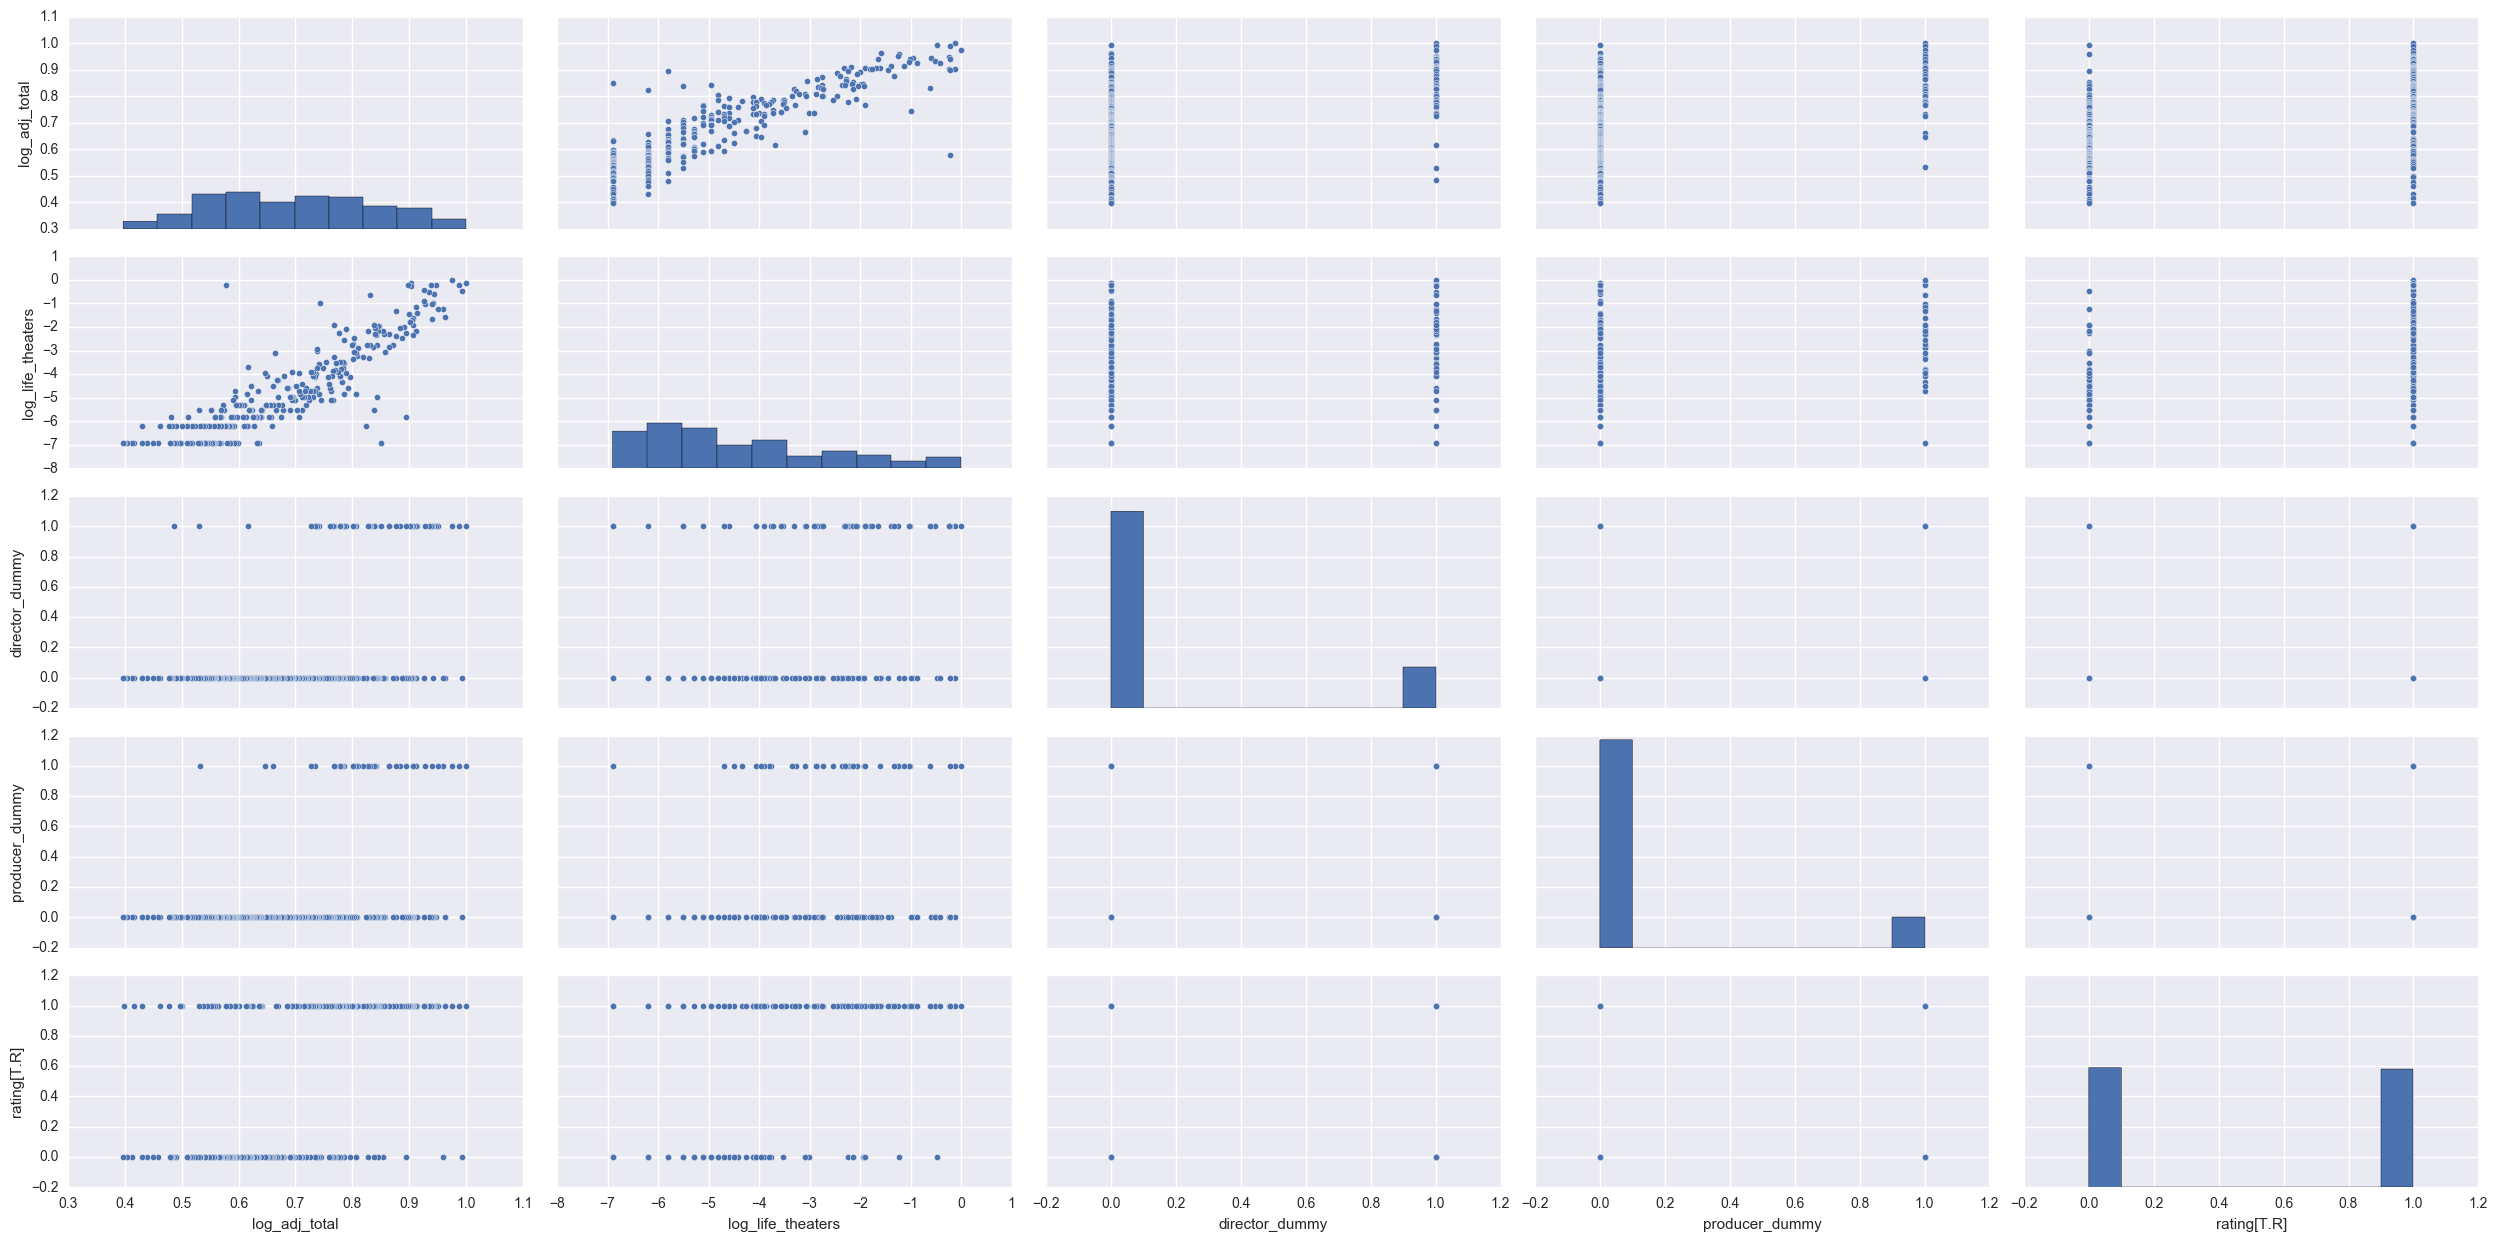

In [43]:
sns.pairplot(df7[['log_adj_total', 'log_life_theaters', 'director_dummy', 'producer_dummy','rating[T.R]']].dropna(), size = 2.5, aspect=2)


In [44]:
df8 = df7[['log_adj_total','life_theaters', 'director_dummy', 'producer_dummy','rating[T.R]']]

In [45]:
df8.corr()

,log_adj_total,life_theaters,director_dummy,producer_dummy,rating[T.R]
log_adj_total,1.000000,0.561865,0.461540,0.379023,0.466103
life_theaters,0.561865,1.000000,0.378947,0.262669,0.317679
director_dummy,0.461540,0.378947,1.000000,0.441214,0.236113
producer_dummy,0.379023,0.262669,0.441214,1.000000,0.129140
rating[T.R],0.466103,0.317679,0.236113,0.129140,1.000000
